In [1]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI,OpenAIEmbeddings #this to above classes we used to interact with llm model.
from dotenv import load_dotenv
from langgraph.graph import StateGraph,END,START #this class we used to build stateful workflows in graphical form mei.
from pydantic import BaseModel,Field,computed_field
from typing import Annotated,List,Dict,TypedDict,Optional
from langchain_core.output_parsers import PydanticOutputParser,StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint

load_dotenv()

True

# step:1) creating Model object

In [2]:
#Groq Model object
model1 = ChatGroq(
    model="groq/compound-mini",
    temperature=0.2
)
model1

#openAI model object.
model2 = ChatOpenAI(temperature=0.2)

## Hugging Face endpoint define karo OPen source Model chat or Generation Model.
llm = HuggingFaceEndpoint(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
)

# Chat model object banao
model3 = ChatHuggingFace(llm=llm)

# step:1) defining state or memory field by using pydantic class then after we create stategraph object

In [3]:
class QuadraticState(BaseModel):
    a: Annotated[int, Field(..., description="Coefficient 'a' of the quadratic equation (must not be 0).")]
    b: Annotated[int, Field(..., description="Coefficient 'b' of the quadratic equation.")]
    c: Annotated[int, Field(..., description="Coefficient 'c' of the quadratic equation.")]
    
    equation: Annotated[
        Optional[str],
        Field(None, description="The quadratic equation in the form ax² + bx + c = 0.")
    ]
    
    discriminant: Annotated[
        Optional[float],
        Field(None, description="The discriminant value (D = b² - 4ac). Determines the nature of the roots.")
    ]
    
    result: Annotated[
        Optional[str],
        Field(None, description="The calculated roots of the quadratic equation.")
    ]


In [4]:
#creating state object by using graphstate class.
graph = StateGraph(QuadraticState)
graph

In [5]:
parser  = StrOutputParser()

# step:2) adding nodes and edges to graph

In [6]:
#creating  node of show_quadratic_equation by using python function in this function they perform action.
def show_quadratic_equation(state:QuadraticState) ->QuadraticState:
    #fetching the field from the state class.
    a = state.a
    b = state.b
    c = state.c
    
    #creating structure instruction prompt
    prompt = PromptTemplate(
    template="""
    You are a math expert. 
    A quadratic equation is defined as: ax² + bx + c = 0. 
    The coefficients are:
    - a = {a}
    - b = {b}
    - c = {c}

    Task:
    1. Write the quadratic equation in standard form.

    Return the response in the following format:
    Equation: ...
    """,
    input_variables=["a", "b", "c"]
)
    
    #now passing this prompt to model in the form of chain.
    chain = prompt | model1 | parser
    
    #now invoking the chain and generate response
    result = chain.invoke({'a':a,'b':b,'c':c}) 
    
    #now updating the state object by using partial state concept after then returning the updated state.
    return {
        "equation": result
    }

In [7]:
def show_discriminant(state:QuadraticState) ->QuadraticState:
    #fetching the field from the state class.
    a = state.a
    b = state.b
    c = state.c
    
    # discriminant calculate karte hai directly
    D = (b ** 2) - (4 * a * c)
    #now updating the state object by using partial state concept after then returning the updated state.
    return {
        "discriminant": D
    }
    

In [8]:
import math

def real_root(state:QuadraticState) ->QuadraticState:
    a = state.a
    b = state.b
    c = state.c
    D = state.discriminant
    
    #formula to get root of x
    root1 = (-b + math.sqrt(D)) / (2 * a)
    root2 = (-b - math.sqrt(D)) / (2 * a)
    
    return {
        'result': f"the real roots are {root1} and {root2}"
    }
    

In [9]:
def equal_root(state:QuadraticState) ->QuadraticState:
    a = state.a
    b = state.b
    c = state.c
    D = state.discriminant
    
    #formula to get root of x
    root1 = (-b ) / (2 * a)
    
    return {
        'result': f"the equal roots are {root1} "
    }
    

In [10]:
import math

def imaginary_root(state:QuadraticState) ->QuadraticState:

    return {
        'result': f"the imaginary roots"
    }
    

# using helper function to check the condition

In [11]:
from typing import Literal
def check_condition(state:QuadraticState) ->Literal['real_root','equal_root','imaginary_root']:
    # fetching the  field from state class.
    D = state.discriminant
    
    if D>0:
        return "real_root"
    
    elif D<0:
        return "imaginary_root"
    
    elif D==0:
        return "equal_root"
    

In [ ]:
#adding the nodes to the graph.
graph.add_node(node='show_quadratic_equation',action=show_quadratic_equation)
graph.add_node(node='show_discriminant',action=show_discriminant)
graph.add_node(node='real_root',action=real_root)
graph.add_node(node='equal_root',action=equal_root)
graph.add_node(node='imaginary_root',action=imaginary_root)

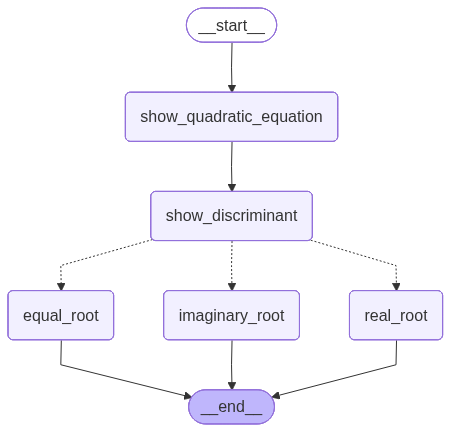

In [ ]:
#adding the edges to graph
graph.add_edge(START,'show_quadratic_equation')
graph.add_edge('show_quadratic_equation','show_discriminant')
#now adding the condition to edge.
graph.add_conditional_edges('show_discriminant',check_condition) ## function that returns the key for the next node

#connecting condition nodes to END
graph.add_edge('real_root',END)
graph.add_edge('equal_root',END)
graph.add_edge('imaginary_root',END)

graph.compile()

In [14]:
#now compiling the graph.
worklfow = graph.compile()

#now invoking the workflow.
#defining the initial_state.
initial_state = QuadraticState(a=4,b=2,c=3) #passing initial to workflow this will share throught out workflow.


response = worklfow.invoke(initial_state)
response

{'a': 4,
 'b': 2,
 'c': 3,
 'equation': 'To write the quadratic equation in standard form, I will substitute the given coefficients into the general equation.\n\nThe general form of a quadratic equation is: ax² + bx + c = 0\n\nGiven coefficients:\n- a = 4\n- b = 2\n- c = 3\n\nSubstituting these values into the general equation:\n\nEquation: 4x² + 2x + 3 = 0',
 'discriminant': -44,
 'result': 'the imaginary roots'}